In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd

session_engine = create_engine('sqlite:///F24.ML.Assignment.One.data.db')

In [ ]:
create_table_query = """
CREATE TABLE IF NOT EXISTS new_table AS
SELECT
    oh.store_id,
    oh.order_id,
    ob.products,
    ob.order_price,
    opv.profit,
    opv.delivery_distance,
    oh.DATE_CREATE AS date_create,
    opv.order_start_prepare,
    oh.planned_prep_time,
    opv.order_ready,
    opv.order_pickup,
    opv.region_id,
    oh.STATUS_ID AS status_id
FROM
    order_history AS oh
LEFT JOIN (
        SELECT
            store_id,
            order_id,

            COUNT(product_id) AS products,
            SUM(price) AS order_price
        FROM
            order_busket
        GROUP BY
            store_id,
            order_id
    ) AS ob ON ob.order_id = oh.order_id AND ob.store_id = oh.store_id
LEFT JOIN (
        SELECT
            order_id,
            MAX(CASE WHEN ORDER_PROPS_ID = 77 THEN VALUE END) AS profit,
            MAX(CASE WHEN ORDER_PROPS_ID = 65 THEN VALUE END) AS delivery_distance,
            MAX(CASE WHEN ORDER_PROPS_ID = 95 THEN VALUE END) AS order_ready,
            MAX(CASE WHEN ORDER_PROPS_ID = 97 THEN VALUE END) AS order_start_prepare,
            MAX(CASE WHEN ORDER_PROPS_ID = 11 THEN VALUE END) AS region_id,
            MAX(CASE WHEN ORDER_PROPS_ID = 18 THEN VALUE END) AS order_pickup
        FROM
            order_props_value
        GROUP BY
            order_id
    ) AS opv ON opv.order_id = oh.order_id;
"""

**Task 1**

In [41]:
with session_engine.connect() as conn:
    conn.execute(text(create_table_query))

query = "SELECT * FROM new_table;"

with session_engine.connect() as conn:
    new_table_df = pd.read_sql_query(text(query), conn)

print(new_table_df.head())
print(new_table_df.info())

   store_id  order_id  products  order_price              profit  \
0      5014  20562761         2       56.880              45.504   
1      3856  20562753         2       60.672              30.336   
2     10825  20562723         1       54.510  43.608000000000004   
3      5640  20562673         2       41.080              32.864   
4      7283  20562665         1       22.120               11.06   

  delivery_distance          date_create  order_start_prepare  \
0              2205  2024-09-05 15:25:25  2024-09-05 15:25:33   
1              1368  2024-09-05 15:25:12  2024-09-05 15:25:19   
2               459  2024-09-05 15:23:32  2024-09-05 15:23:44   
3              2611     2024-09-05 15:19  2024-09-05 15:19:05   
4              1041  2024-09-05 15:18:39                 None   

   planned_prep_time          order_ready         order_pickup region_id  \
0               15.0  2024-09-05 15:32:00  05-09-2024 16:00:00       683   
1               10.0  2024-09-05 15:35:50  05-09

In [42]:
new_table_df.head()

,store_id,order_id,products,order_price,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id
0,5014,20562761,2,56.880,45.504,2205,2024-09-05 15:25:25,2024-09-05 15:25:33,15.0,2024-09-05 15:32:00,05-09-2024 16:00:00,683,F
1,3856,20562753,2,60.672,30.336,1368,2024-09-05 15:25:12,2024-09-05 15:25:19,10.0,2024-09-05 15:35:50,05-09-2024 16:03:50,683,F
2,10825,20562723,1,54.510,43.608000000000004,459,2024-09-05 15:23:32,2024-09-05 15:23:44,20.0,2024-09-05 15:38:38,05-09-2024 16:06:38,683,F
3,5640,20562673,2,41.080,32.864,2611,2024-09-05 15:19,2024-09-05 15:19:05,20.0,2024-09-05 15:35:25,05-09-2024 16:03:25,709,F
4,7283,20562665,1,22.120,11.06,1041,2024-09-05 15:18:39,None,15.0,2024-09-05 15:35:33,05-09-2024 16:03:33,707,F


In [43]:
print(new_table_df.describe())

            store_id      order_id       products    order_price  \
count  517610.000000  5.176100e+05  517610.000000  502626.000000   
mean     6681.590711  1.962557e+07       2.611410      80.266662   
std      2710.745860  5.474842e+05       1.570025      64.562313   
min      3053.000000  1.867122e+07       1.000000       4.029000   
25%      4008.000000  1.914967e+07       1.000000      39.500000   
50%      6205.000000  1.963311e+07       2.000000      63.595000   
75%      9217.000000  2.009969e+07       3.000000     101.357000   
max     11965.000000  2.056276e+07      31.000000    2007.390000   

       planned_prep_time  
count      517609.000000  
mean           23.241360  
std             8.301033  
min             0.000000  
25%            20.000000  
50%            20.000000  
75%            30.000000  
max           180.000000  


In [44]:
missing_values = new_table_df.isnull().sum()
print(missing_values[missing_values > 0])

order_price            14984
profit                 51385
date_create              273
order_start_prepare    51796
planned_prep_time          1
order_ready            51366
dtype: int64


In [45]:
new_table_df['date_create'] = pd.to_datetime(new_table_df['date_create'], errors='coerce')
new_table_df['order_start_prepare'] = pd.to_datetime(new_table_df['order_start_prepare'], errors='coerce')
new_table_df['order_ready'] = pd.to_datetime(new_table_df['order_ready'], errors='coerce')
new_table_df['order_pickup'] = pd.to_datetime(new_table_df['order_pickup'], format='%d-%m-%Y %H:%M:%S', errors='coerce')

In [46]:
count_F = (new_table_df['status_id'] == 'F').sum()

total_count = new_table_df['status_id'].count()

percentage_F = (count_F / total_count) * 100

percentage_F

99.9795212611812

In [47]:
unique_count = new_table_df['order_id'].nunique()

total_count = new_table_df['order_id'].count()

percentage_unique = (unique_count / total_count) * 100

percentage_unique

100.0

In [48]:
new_table_df.drop(columns=['status_id'], inplace=True)

new_table_df.drop(columns=['order_id'], inplace=True)

In [49]:
valid_rows = new_table_df[
    (new_table_df['date_create'] < new_table_df['order_start_prepare']) &
    (new_table_df['order_start_prepare'] < new_table_df['order_ready']) &
    (new_table_df['order_ready'] < new_table_df['order_pickup'])
]

new_table_df = valid_rows

new_table_df['actual_prep_time'] = (new_table_df['order_ready'] - new_table_df['order_start_prepare']).dt.total_seconds() / 60.0

In [50]:
new_table_df['actual_prep_time'].describe()

,actual_prep_time
count,388195.000000
mean,21.322985
std,11.308934
min,0.016667
25%,13.483333
50%,19.616667
75%,27.366667
max,549.583333


In [51]:
new_table_df['profit'] = new_table_df['profit'].astype(float)
new_table_df['delivery_distance'] = new_table_df['delivery_distance'].astype(int)

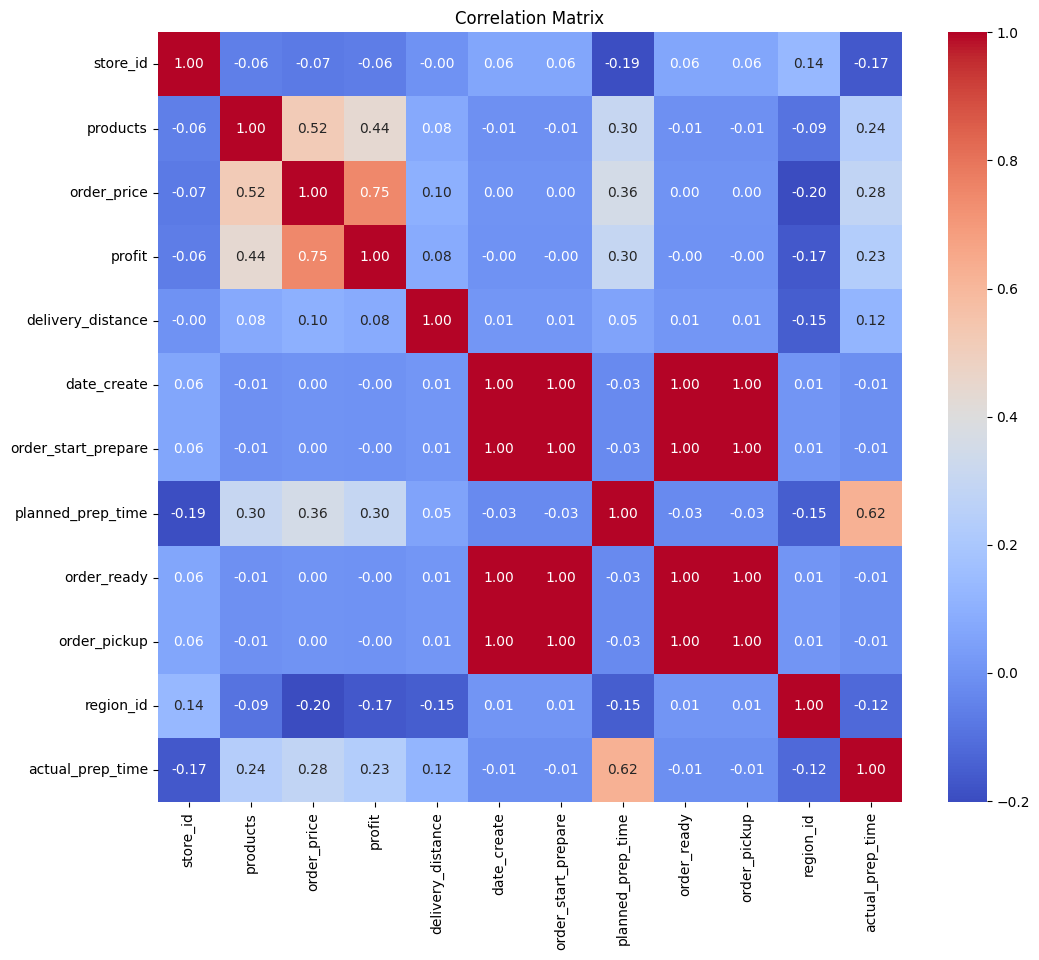

In [52]:
import seaborn as sns

plt.figure(figsize=(12, 10))
correlation_matrix = new_table_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [53]:
new_table_df['create_month'] = new_table_df['date_create'].dt.month
new_table_df['create_day'] = new_table_df['date_create'].dt.day
new_table_df['create_hour'] = new_table_df['date_create'].dt.hour
new_table_df['create_minute'] = new_table_df['date_create'].dt.minute

new_table_df['prepare_month'] = new_table_df['order_start_prepare'].dt.month
new_table_df['prepare_day'] = new_table_df['order_start_prepare'].dt.day
new_table_df['prepare_hour'] = new_table_df['order_start_prepare'].dt.hour
new_table_df['prepare_minute'] = new_table_df['order_start_prepare'].dt.minute

new_table_df['day_of_week'] = new_table_df['date_create'].dt.dayofweek
new_table_df['hour_of_day'] = new_table_df['date_create'].dt.hour
new_table_df['season'] = new_table_df['date_create'].dt.month % 12 // 3 + 1

new_table_df['profit_to_price_ratio'] = new_table_df['profit'] / new_table_df['order_price']

new_table_df.drop(columns=['date_create',
                 'order_start_prepare',
                 'order_ready',
                 'order_pickup'], inplace=True)

new_table_df['is_morning'] = new_table_df['create_hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)
new_table_df['is_evening'] = new_table_df['create_hour'].apply(lambda x: 1 if 17 <= x < 21 else 0)
new_table_df['days_since_month_start'] = new_table_df['create_day']

daily_orders = new_table_df.groupby(['create_month', 'create_day']).size().reset_index(name='daily_order_count')
new_table_df = new_table_df.merge(daily_orders, on=['create_month', 'create_day'], how='left')

In [54]:
correlation_with_target = correlation_matrix['actual_prep_time'].sort_values(ascending=False)
print(correlation_with_target)

actual_prep_time       1.000000
planned_prep_time      0.623438
order_price            0.282730
products               0.237699
profit                 0.234406
delivery_distance      0.119572
order_ready           -0.012946
order_pickup          -0.012946
date_create           -0.013169
order_start_prepare   -0.013173
region_id             -0.120282
store_id              -0.168791
Name: actual_prep_time, dtype: float64


In [55]:
for column in new_table_df.columns:
    if new_table_df[column].dtype == 'object':
        unique_values = new_table_df[column].nunique()
        print(f"Column '{column}' has {unique_values} unique values.")

Column 'region_id' has 13 unique values.


In [56]:
region_distribution = new_table_df.groupby('region_id')['actual_prep_time'].mean().reset_index()
print("Average preparation time by region:")
print(region_distribution)

region_counts = new_table_df['region_id'].value_counts().reset_index()
region_counts.columns = ['region_id', 'count']
print("\nNumber of records for each region:")
print(region_counts)

Average preparation time by region:
   region_id  actual_prep_time
0        683         21.912879
1        685         26.438385
2        687         21.523987
3        689         20.609756
4        691         19.889888
5        693         18.278729
6        695         20.986637
7        697         24.988376
8        703         18.352634
9        705         17.949386
10       707         19.364473
11       709         18.591164
12       717         17.908322

Number of records for each region:
   region_id   count
0        683  191240
1        707   61836
2        695   31560
3        685   29493
4        703   18581
5        689   11714
6        693   10053
7        691    8833
8        687    7147
9        709    6419
10       697    4161
11       717    3739
12       705    3419


In [57]:
def remove_outliers_iqr(group):

    for column in group.select_dtypes(include=[np.number]).columns:
        Q1 = group[column].quantile(0.25)
        Q3 = group[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
    return group

new_table_df = new_table_df.groupby('store_id').apply(remove_outliers_iqr).reset_index(drop=True)
threshold = 10
new_table_df = new_table_df[
    (np.abs(new_table_df['actual_prep_time'] - new_table_df['planned_prep_time']) <= threshold)
]

print("DataFrame information after removing outliers:")
print(new_table_df.info())

DataFrame information after removing outliers:
<class 'pandas.core.frame.DataFrame'>
Index: 148490 entries, 0 to 188446
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   store_id                148490 non-null  int64  
 1   products                148490 non-null  int64  
 2   order_price             148490 non-null  float64
 3   profit                  148490 non-null  float64
 4   delivery_distance       148490 non-null  int64  
 5   planned_prep_time       148490 non-null  float64
 6   region_id               148490 non-null  object 
 7   actual_prep_time        148490 non-null  float64
 8   create_month            148490 non-null  int32  
 9   create_day              148490 non-null  int32  
 10  create_hour             148490 non-null  int32  
 11  create_minute           148490 non-null  int32  
 12  prepare_month           148490 non-null  int32  
 13  prepare_day             148490 n

<ipython-input-57-96305e7fa784>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_table_df = new_table_df.groupby('store_id').apply(remove_outliers_iqr).reset_index(drop=True)


In [58]:
X = new_table_df.drop(columns=['actual_prep_time'])
y = new_table_df['actual_prep_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133641 entries, 22983 to 155742
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   store_id                133641 non-null  int64  
 1   products                133641 non-null  int64  
 2   order_price             133641 non-null  float64
 3   profit                  133641 non-null  float64
 4   delivery_distance       133641 non-null  int64  
 5   planned_prep_time       133641 non-null  float64
 6   region_id               133641 non-null  object 
 7   create_month            133641 non-null  int32  
 8   create_day              133641 non-null  int32  
 9   create_hour             133641 non-null  int32  
 10  create_minute           133641 non-null  int32  
 11  prepare_month           133641 non-null  int32  
 12  prepare_day             133641 non-null  int32  
 13  prepare_hour            133641 non-null  int32  
 14  prepare_minute       

In [60]:
def inpute_missing_values(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)

    datetime_cols = df.select_dtypes(include=[np.datetime64]).columns.tolist()
    for col in datetime_cols:
        if df[col].isnull().sum() > 0:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)

    return df

X_train_inputed = inpute_missing_values(X_train.copy())
X_test_inputed = inpute_missing_values(X_test.copy())

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.7 MB/s eta 0:00:00


In [61]:
from category_encoders import BinaryEncoder
cat_feats = X_train_inputed.select_dtypes(include=['object']).columns.tolist()
bn = BinaryEncoder(cols=cat_feats)

X_train_encoded = bn.fit_transform(X_train_inputed)
X_test_encoded = bn.transform(X_test_inputed)

In [62]:
from sklearn.preprocessing import RobustScaler
numeric_features = X_train_encoded.select_dtypes(include=['number'])

scaler = RobustScaler()
scaler.fit(numeric_features)

scaled_features_train = scaler.transform(numeric_features)
scaled_features_test = scaler.transform(X_test_encoded[numeric_features.columns])

scaled_features_train_df = pd.DataFrame(scaled_features_train, columns=numeric_features.columns, index=X_train_encoded.index)
scaled_features_test_df = pd.DataFrame(scaled_features_test, columns=numeric_features.columns, index=X_test_encoded.index)

X_train_final = pd.concat([scaled_features_train_df, X_train_encoded.drop(columns=numeric_features.columns)], axis=1)
X_test_final = pd.concat([scaled_features_test_df, X_test_encoded.drop(columns=numeric_features.columns)], axis=1)


In [63]:
print("Scaled and Encoded Training Features:")
print(X_train_final.head())

print("Scaled and Encoded Testing Features:")
print(X_test_final.head())

Scaled and Encoded Training Features:
        store_id  products  order_price    profit  delivery_distance  \
22983  -0.584106       0.5     0.000000 -0.441048          -0.679440   
137239  0.512707       0.5    -0.197183 -0.375546           0.309122   
153630  0.662767       0.0    -0.653521 -0.643668           0.166714   
26010  -0.567568       0.0     0.126761  2.200873           1.386331   
118036  0.376765       0.0    -0.084507 -0.467249          -0.177009   

        planned_prep_time  region_id_0  region_id_1  region_id_2  region_id_3  \
22983                 0.5          0.0          0.0          0.0          0.0   
137239                0.0          0.0          0.0          0.0          0.0   
153630                0.0          0.0          0.0          1.0         -1.0   
26010                 0.5          0.0          0.0          0.0          0.0   
118036               -0.5          0.0          0.0          1.0          0.0   

        ...  prepare_hour  prepare_minute 

In [64]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

LinearRegression()

In [65]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_final, y_train)

Ridge()

In [66]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_final, y_train)

RandomForestRegressor(random_state=42)

In [67]:
from sklearn import metrics

def evaluate_model(model):
    y_pred = model.predict(X_test_final)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    return mae, mse, r2

models = {
    'Linear Regression': lin_reg,
    'Ridge Regression': ridge_reg,
    'Random Forest Regression': rf_reg
}

for name, model in models.items():
    mae, mse, r2 = evaluate_model(model)
    print(f"{name}: MAE={mae:.2f}, MSE={mse:.2f}, R²={r2:.2f}")

Linear Regression: MAE=3.97, MSE=23.04, R²=0.69
Ridge Regression: MAE=3.97, MSE=23.05, R²=0.69
Random Forest Regression: MAE=3.93, MSE=22.80, R²=0.69


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

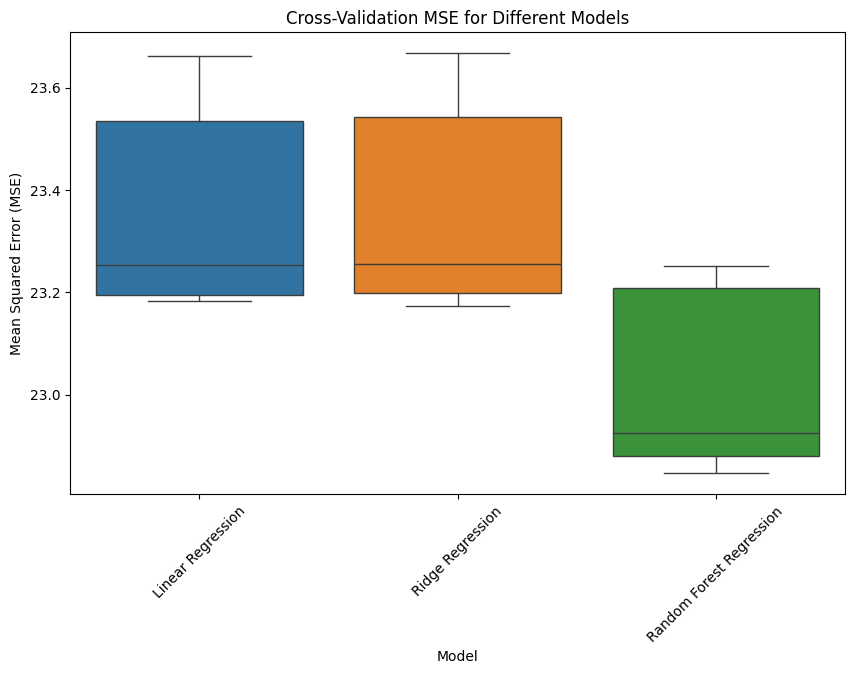

Cross-Validation Results (MSE):
   Linear Regression  Ridge Regression  Random Forest Regression
1          23.661320         23.667736                 23.252294
2          23.182921         23.173287                 22.846786
3          23.253054         23.255699                 22.879613
4          23.535343         23.542095                 23.209034
5          23.194732         23.199695                 22.924925
Linear Regression:
  Training R²: 0.6869
  Mean Cross-Validation MSE: 23.3655
  Likely underfitting.
Ridge Regression:
  Training R²: 0.6869
  Mean Cross-Validation MSE: 23.3677
  Likely underfitting.
Random Forest Regression:
  Training R²: 0.9570
  Mean Cross-Validation MSE: 23.0225
  Likely overfitting.


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_final, y_train, cv=kf, scoring='neg_mean_squared_error')
    results[name] = -cv_scores

results_df = pd.DataFrame(results)
results_df.index += 1

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df)
plt.title('Cross-Validation MSE for Different Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

print("Cross-Validation Results (MSE):")
print(results_df)

for name, model in models.items():
    model.fit(X_train_final, y_train)
    train_score = model.score(X_train_final, y_train)
    cv_score = np.mean(results[name])

    print(f"{name}:")
    print(f"  Training R²: {train_score:.4f}")
    print(f"  Mean Cross-Validation MSE: {cv_score:.4f}")

    if train_score < 0.7 and cv_score > 0.1:
        print("  Likely underfitting.")
    elif train_score > 0.9 and cv_score > train_score:
        print("  Likely overfitting.")
    else:
        print("  Model is performing well.")

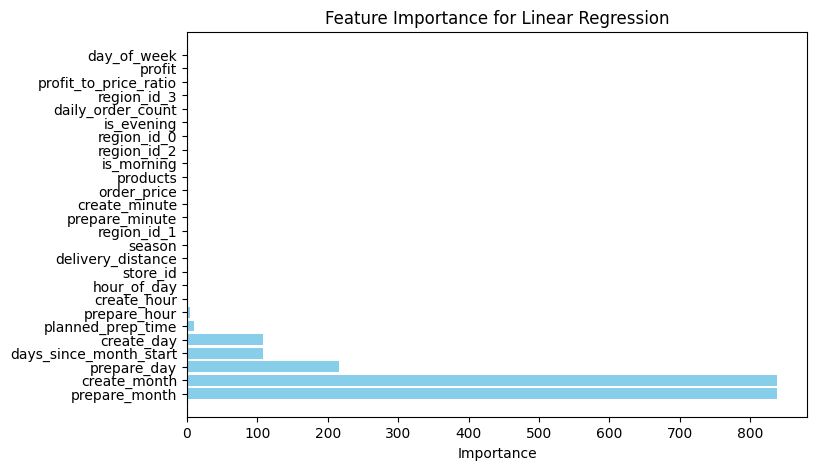

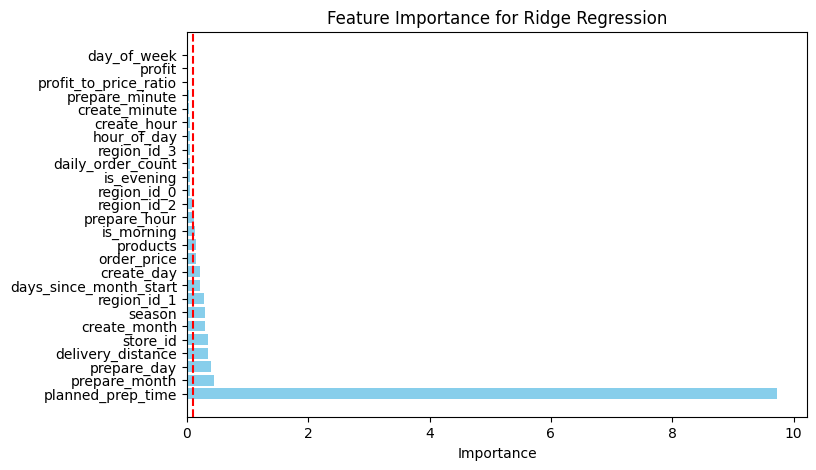

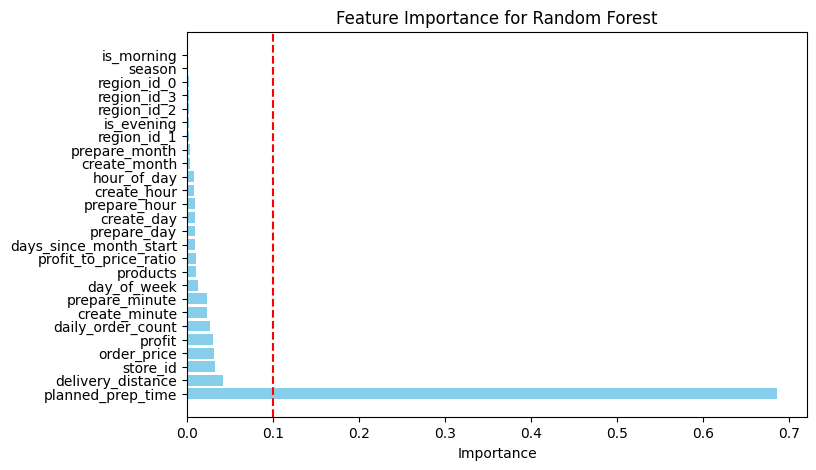

Significant Features:
Linear Regression:                    Feature  Importance
14           prepare_month  838.784161
10            create_month  838.640588
15             prepare_day  215.686303
24  days_since_month_start  107.824467
11              create_day  107.824467
5        planned_prep_time    9.737329
16            prepare_hour    3.781161
12             create_hour    1.904988
19             hour_of_day    1.904988
0                 store_id    0.347209
4        delivery_distance    0.345168
20                  season    0.306066
7              region_id_1    0.287583
17          prepare_minute    0.245492
13           create_minute    0.241080
2              order_price    0.155541
1                 products    0.148276
22              is_morning    0.128086
Ridge Regression:                    Feature  Importance
5        planned_prep_time    9.735274
14           prepare_month    0.437945
15             prepare_day    0.389898
4        delivery_distance    0.351585
0    

In [ ]:
feature_names = X_train_final.columns
lin_importance = np.abs(lin_reg.coef_)
ridge_importance = np.abs(ridge_reg.coef_)
rf_importance = rf_reg.feature_importances_

lin_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lin_importance}).sort_values(by='Importance', ascending=False)
ridge_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': ridge_importance}).sort_values(by='Importance', ascending=False)
rf_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importance}).sort_values(by='Importance', ascending=False)

threshold = 0.1

def plot_feature_importance(importance_df, model_name):
    plt.figure(figsize=(8, 5))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.axvline(x=threshold, color='red', linestyle='--')
    plt.title(f'Feature Importance for {model_name}')
    plt.xlabel('Importance')
    plt.show()

plot_feature_importance(lin_importance_df, 'Linear Regression')
plot_feature_importance(ridge_importance_df, 'Ridge Regression')
plot_feature_importance(rf_importance_df, 'Random Forest')

print("Significant Features:")
print("Linear Regression:", lin_importance_df[lin_importance_df['Importance'] > threshold])
print("Ridge Regression:", ridge_importance_df[ridge_importance_df['Importance'] > threshold])
print("Random Forest:", rf_importance_df[rf_importance_df['Importance'] > threshold])

**Task 2**

In [36]:
with session_engine.connect() as conn:
    conn.execute(text(create_table_query))

query = "SELECT * FROM new_table;"

with session_engine.connect() as conn:
    new_table_df = pd.read_sql_query(text(query), conn)

print(new_table_df.head())
print(new_table_df.info())

   store_id  order_id  products  order_price              profit  \
0      5014  20562761         2       56.880              45.504   
1      3856  20562753         2       60.672              30.336   
2     10825  20562723         1       54.510  43.608000000000004   
3      5640  20562673         2       41.080              32.864   
4      7283  20562665         1       22.120               11.06   

  delivery_distance          date_create  order_start_prepare  \
0              2205  2024-09-05 15:25:25  2024-09-05 15:25:33   
1              1368  2024-09-05 15:25:12  2024-09-05 15:25:19   
2               459  2024-09-05 15:23:32  2024-09-05 15:23:44   
3              2611     2024-09-05 15:19  2024-09-05 15:19:05   
4              1041  2024-09-05 15:18:39                 None   

   planned_prep_time          order_ready         order_pickup region_id  \
0               15.0  2024-09-05 15:32:00  05-09-2024 16:00:00       683   
1               10.0  2024-09-05 15:35:50  05-09

In [37]:
new_table_df['date_create'] = pd.to_datetime(new_table_df['date_create'], errors='coerce')
new_table_df['order_start_prepare'] = pd.to_datetime(new_table_df['order_start_prepare'], errors='coerce')
new_table_df['order_ready'] = pd.to_datetime(new_table_df['order_ready'], errors='coerce')
new_table_df['order_pickup'] = pd.to_datetime(new_table_df['order_pickup'], format='%d-%m-%Y %H:%M:%S', errors='coerce')

valid_rows = new_table_df[
    (new_table_df['date_create'] < new_table_df['order_start_prepare']) &
    (new_table_df['order_start_prepare'] < new_table_df['order_ready']) &
    (new_table_df['order_ready'] < new_table_df['order_pickup'])
]

new_table_df = valid_rows

new_table_df['actual_prep_time'] = (new_table_df['order_ready'] - new_table_df['order_start_prepare']).dt.total_seconds() / 60.0

new_table_df['profit'] = pd.to_numeric(new_table_df['profit'], errors='coerce')
new_table_df['delivery_distance'] = pd.to_numeric(new_table_df['delivery_distance'], errors='coerce').astype(int)

new_table_df['create_month'] = new_table_df['date_create'].dt.month
new_table_df['create_day'] = new_table_df['date_create'].dt.day
new_table_df['create_hour'] = new_table_df['date_create'].dt.hour
new_table_df['create_minute'] = new_table_df['date_create'].dt.minute

new_table_df['prepare_month'] = new_table_df['order_start_prepare'].dt.month
new_table_df['prepare_day'] = new_table_df['order_start_prepare'].dt.day
new_table_df['prepare_hour'] = new_table_df['order_start_prepare'].dt.hour
new_table_df['prepare_minute'] = new_table_df['order_start_prepare'].dt.minute

new_table_df['profit_to_price_ratio'] = new_table_df['profit'] / new_table_df['order_price']

new_table_df.drop(columns=['date_create',
                 'order_start_prepare',
                 'order_ready',
                 'order_pickup'], inplace=True)

new_table_df['is_morning'] = new_table_df['create_hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)
new_table_df['is_evening'] = new_table_df['create_hour'].apply(lambda x: 1 if 17 <= x < 21 else 0)
new_table_df['days_since_month_start'] = new_table_df['create_day']

daily_orders = new_table_df.groupby(['create_month', 'create_day']).size().reset_index(name='daily_order_count')
new_table_df = new_table_df.merge(daily_orders, on=['create_month', 'create_day'], how='left')

new_table_df['planned_prep_minutes'] = new_table_df['planned_prep_time']

new_table_df['on_time'] = np.where(abs(new_table_df['planned_prep_minutes'] - new_table_df['actual_prep_time']) <= 5, 1, 0)

new_table_df['profit_distance_interaction'] = new_table_df['profit'] * new_table_df['delivery_distance']

new_table_df.drop(columns=['status_id', 'order_id', 'actual_prep_time', 'planned_prep_time'], inplace=True)

print(new_table_df.head())
print(new_table_df.info())

<ipython-input-37-a5d8f77d2fa9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_table_df['actual_prep_time'] = (new_table_df['order_ready'] - new_table_df['order_start_prepare']).dt.total_seconds() / 60.0


   store_id  products  order_price   profit  delivery_distance region_id  \
0      5014         2       56.880  45.5040               2205       683   
1      3856         2       60.672  30.3360               1368       683   
2     10825         1       54.510  43.6080                459       683   
3      8535         5       45.346  11.3128               1749       685   
4     11449         1        5.530   4.4240               1040       695   

   create_month  create_day  create_hour  create_minute  ...  prepare_hour  \
0             9           5           15             25  ...            15   
1             9           5           15             25  ...            15   
2             9           5           15             23  ...            15   
3             9           5           15             16  ...            15   
4             9           5           15             14  ...            15   

   prepare_minute  profit_to_price_ratio  is_morning  is_evening  \
0     

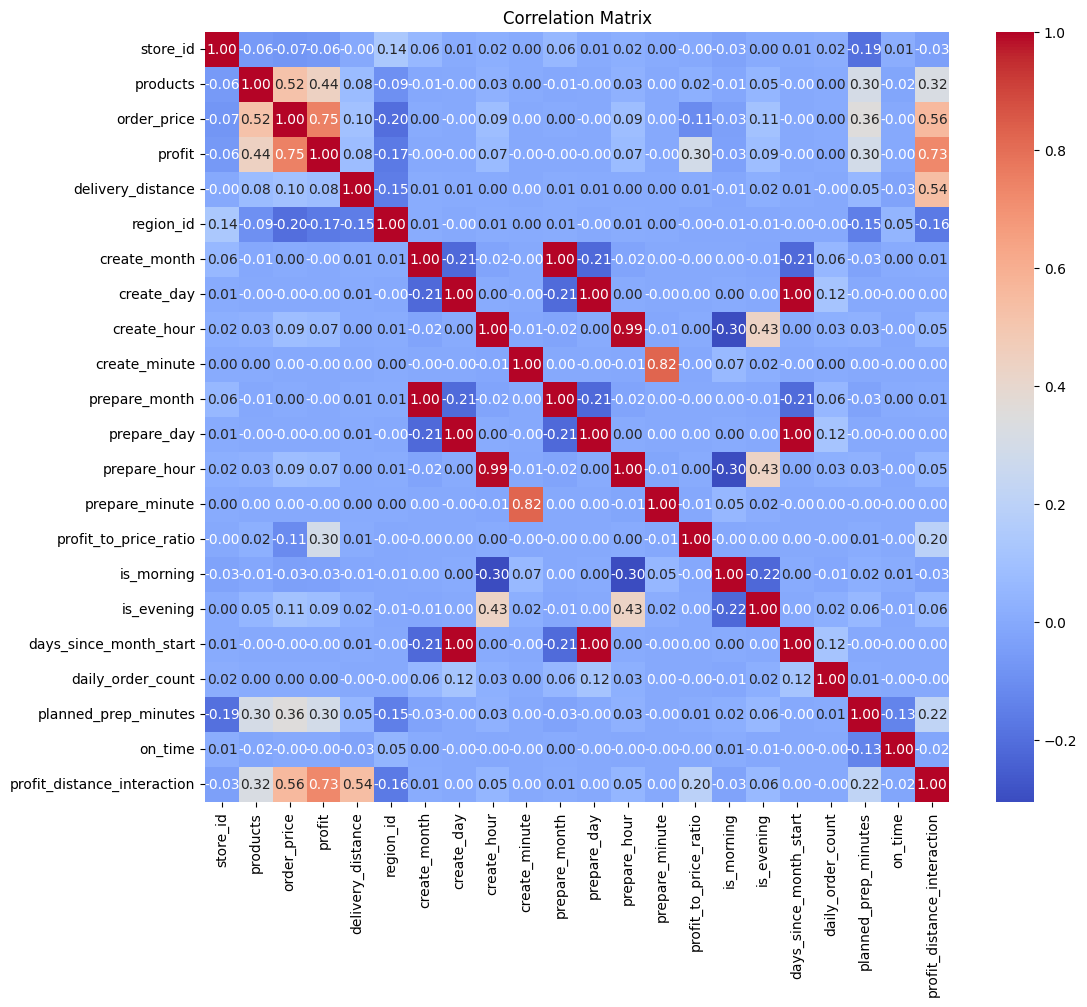

In [38]:
import seaborn as sns

plt.figure(figsize=(12, 10))
correlation_matrix = new_table_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [40]:
correlation_with_target = correlation_matrix['on_time'].sort_values(ascending=False)
print(correlation_with_target)

on_time                        1.000000
region_id                      0.046471
store_id                       0.012745
is_morning                     0.007642
prepare_month                  0.003379
create_month                   0.003370
profit_to_price_ratio         -0.000841
days_since_month_start        -0.001251
create_day                    -0.001251
prepare_day                   -0.001281
create_minute                 -0.002029
prepare_minute                -0.002523
daily_order_count             -0.002966
profit                        -0.003464
order_price                   -0.003549
create_hour                   -0.004055
prepare_hour                  -0.004792
is_evening                    -0.007471
profit_distance_interaction   -0.015112
products                      -0.015353
delivery_distance             -0.025121
planned_prep_minutes          -0.132917
Name: on_time, dtype: float64


In [ ]:
missing_values = new_table_df.isnull().sum()
print(missing_values[missing_values > 0])

order_price                    11153
profit                         38582
profit_to_price_ratio          48669
profit_distance_interaction    38582
dtype: int64


In [ ]:
original_size = new_table_df.shape[0]

numeric_df = new_table_df.select_dtypes(include=[np.number])
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

mask = ~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)
new_table_df_no_outliers = new_table_df[mask]

cleaned_size = new_table_df_no_outliers.shape[0]

reduction = original_size - cleaned_size
reduction_percentage = (reduction / original_size) * 100

print(f"Initial dataset size: {original_size}")
print(f"Cleaned dataset size: {cleaned_size}")
print(f"Number of deleted records: {reduction}")
print(f"Reduction percentage: {reduction_percentage:.2f}%")

Initial dataset size: 388195
Cleaned dataset size: 270958
Number of deleted records: 117237
Reduction percentage: 30.20%


In [ ]:
from sklearn.model_selection import train_test_split

X = new_table_df_no_outliers.drop(columns=['on_time'])
y = new_table_df_no_outliers['on_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
def inpute_missing_values(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)

    datetime_cols = df.select_dtypes(include=[np.datetime64]).columns.tolist()
    for col in datetime_cols:
        if df[col].isnull().sum() > 0:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)

    return df

X_train_inputed = inpute_missing_values(X_train.copy())
X_test_inputed = inpute_missing_values(X_test.copy())

<ipython-input-10-23999ec092f4>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)


In [ ]:
import pandas as pd
from category_encoders import BinaryEncoder

cat_feats = ['region_id', 'store_id']
bn = BinaryEncoder(cols=cat_feats)

X_train_encoded = bn.fit_transform(X_train_inputed)
X_test_encoded = bn.transform(X_test_inputed)

In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_features = X_train_encoded.select_dtypes(include=['number']).columns.tolist()

scaler = StandardScaler()
scaler.fit(X_train_encoded[numeric_features])

scaled_features_train = scaler.transform(X_train_encoded[numeric_features])
scaled_features_test = scaler.transform(X_test_encoded[numeric_features])

scaled_features_train_df = pd.DataFrame(scaled_features_train, columns=numeric_features, index=X_train_encoded.index)
scaled_features_test_df = pd.DataFrame(scaled_features_test, columns=numeric_features, index=X_test_encoded.index)

X_train_final = pd.concat([scaled_features_train_df, X_train_encoded.drop(columns=numeric_features)], axis=1)
X_test_final = pd.concat([scaled_features_test_df, X_test_encoded.drop(columns=numeric_features)], axis=1)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_final, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_resampled, y_resampled)

LogisticRegression()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_resampled, y_resampled)

GradientBoostingClassifier()

In [ ]:
y_pred_logistic = logistic_model.predict(X_test_final)
y_pred_rf = rf_model.predict(X_test_final)
y_pred_gb = gb_model.predict(X_test_final)

Logistic Regression:
  Accuracy: 0.5679
  Precision: 0.5305
  Recall: 0.5980
  F1 Score: 0.5623
  AUC-ROC: 0.5962
Logistic Regression Confusion Matrix Values:
  True Positive (TP): 7519
  True Negative (TN): 7869
  False Positive (FP): 6654
  False Negative (FN): 5054


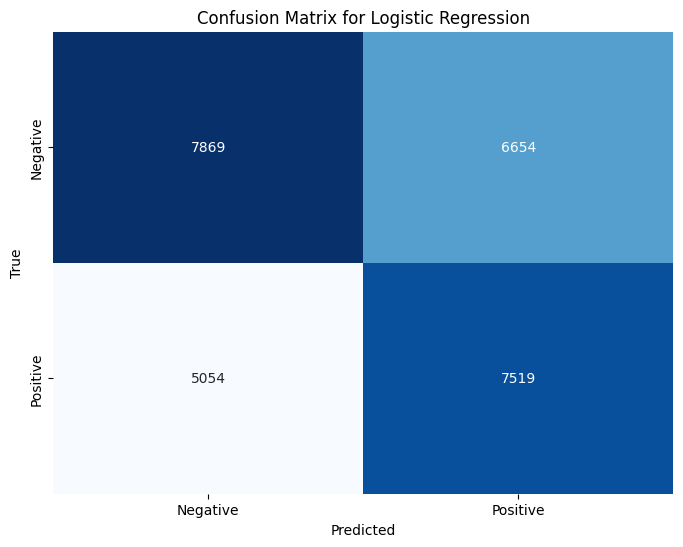


Random Forest:
  Accuracy: 0.5756
  Precision: 0.5545
  Recall: 0.4339
  F1 Score: 0.4869
  AUC-ROC: 0.5956
Random Forest Confusion Matrix Values:
  True Positive (TP): 5456
  True Negative (TN): 10140
  False Positive (FP): 4383
  False Negative (FN): 7117


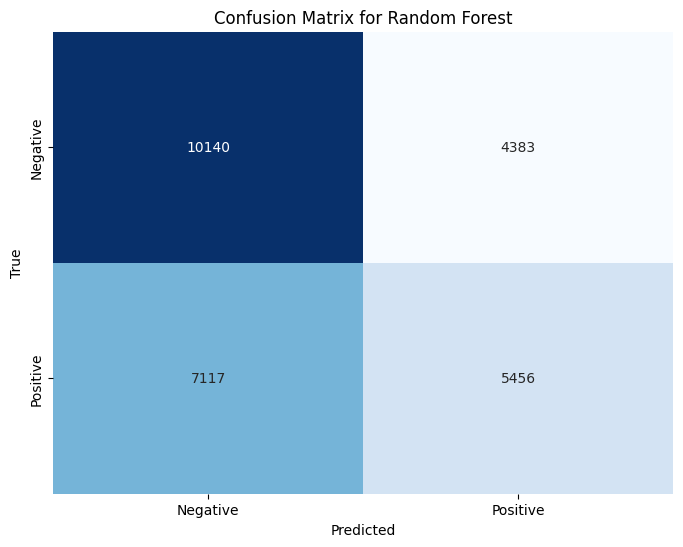


Gradient Boosting:
  Accuracy: 0.5792
  Precision: 0.5614
  Recall: 0.4259
  F1 Score: 0.4844
  AUC-ROC: 0.5963
Gradient Boosting Confusion Matrix Values:
  True Positive (TP): 5355
  True Negative (TN): 10340
  False Positive (FP): 4183
  False Negative (FN): 7218


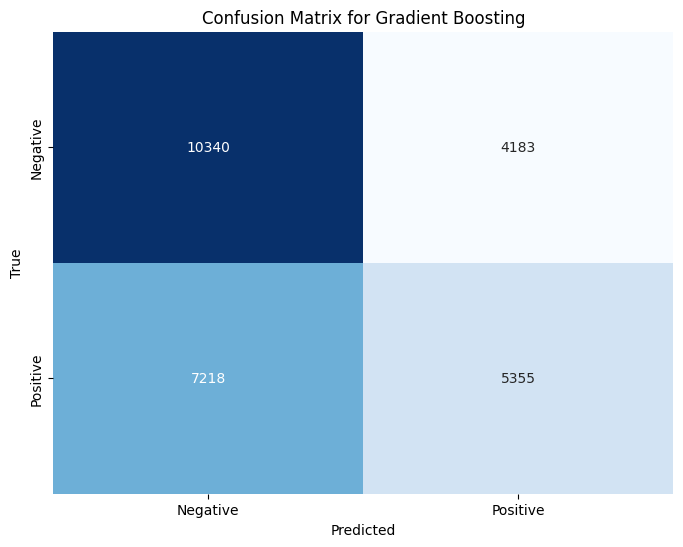

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

def evaluate_model(y_true, y_pred, model):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    if model is not None:
        roc_auc = roc_auc_score(y_true, model.predict_proba(X_test_final)[:, 1])
    else:
        roc_auc = None

    return accuracy, precision, recall, f1, roc_auc

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    print(f"{model_name} Confusion Matrix Values:")
    print(f"  True Positive (TP): {TP}")
    print(f"  True Negative (TN): {TN}")
    print(f"  False Positive (FP): {FP}")
    print(f"  False Negative (FN): {FN}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

metrics_logistic = evaluate_model(y_test, y_pred_logistic, logistic_model)
print("Logistic Regression:")
print(f"  Accuracy: {metrics_logistic[0]:.4f}")
print(f"  Precision: {metrics_logistic[1]:.4f}")
print(f"  Recall: {metrics_logistic[2]:.4f}")
print(f"  F1 Score: {metrics_logistic[3]:.4f}")
print(f"  AUC-ROC: {metrics_logistic[4]:.4f}")

plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression")

metrics_rf = evaluate_model(y_test, y_pred_rf, rf_model)
print("\nRandom Forest:")
print(f"  Accuracy: {metrics_rf[0]:.4f}")
print(f"  Precision: {metrics_rf[1]:.4f}")
print(f"  Recall: {metrics_rf[2]:.4f}")
print(f"  F1 Score: {metrics_rf[3]:.4f}")
print(f"  AUC-ROC: {metrics_rf[4]:.4f}")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

metrics_gb = evaluate_model(y_test, y_pred_gb, gb_model)
print("\nGradient Boosting:")
print(f"  Accuracy: {metrics_gb[0]:.4f}")
print(f"  Precision: {metrics_gb[1]:.4f}")
print(f"  Recall: {metrics_gb[2]:.4f}")
print(f"  F1 Score: {metrics_gb[3]:.4f}")
print(f"  AUC-ROC: {metrics_gb[4]:.4f}")

plot_confusion_matrix(y_test, y_pred_gb, "Gradient Boosting")

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    return np.mean(scores), np.std(scores)

In [ ]:
logistic_model = LogisticRegression()
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()

logistic_cv = cross_validate_model(logistic_model, X_resampled, y_resampled)
rf_cv = cross_validate_model(rf_model, X_resampled, y_resampled)
gb_cv = cross_validate_model(gb_model, X_resampled, y_resampled)

print("Cross-Validation Results:")
print(f"Logistic Regression: Mean F1 Score: {logistic_cv[0]:.4f}, Std: {logistic_cv[1]:.4f}")
print(f"Random Forest: Mean F1 Score: {rf_cv[0]:.4f}, Std: {rf_cv[1]:.4f}")
print(f"Gradient Boosting: Mean F1 Score: {gb_cv[0]:.4f}, Std: {gb_cv[1]:.4f}")

Cross-Validation Results:
Logistic Regression: Mean F1 Score: 0.5799, Std: 0.0035
Random Forest: Mean F1 Score: 0.5570, Std: 0.0922
Gradient Boosting: Mean F1 Score: 0.4955, Std: 0.0320


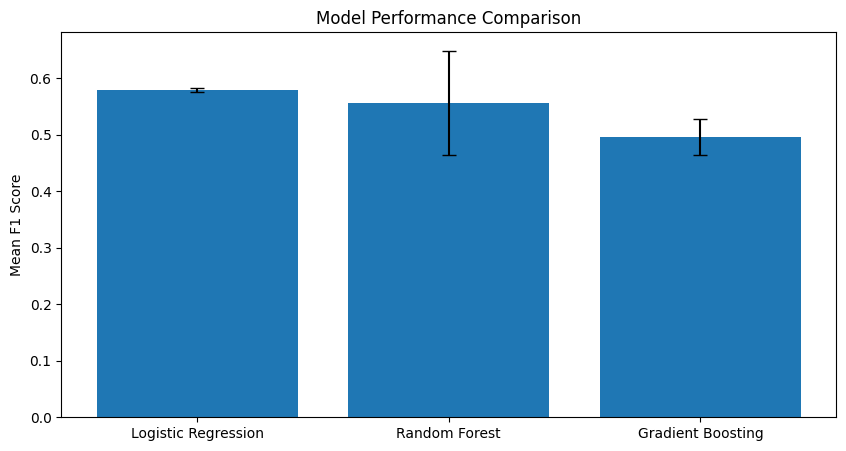

In [ ]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
mean_f1_scores = [0.5799, 0.5570, 0.4955]
std_devs = [0.0035, 0.0922, 0.0320]

# Bar plot for Mean F1 Scores
plt.figure(figsize=(10, 5))
plt.bar(models, mean_f1_scores, yerr=std_devs, capsize=5)
plt.ylabel('Mean F1 Score')
plt.title('Model Performance Comparison')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_resampled, y_resampled)

coefficients = logistic_model.coef_[0]
feature_importance_logistic = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Coefficient': coefficients
})

feature_importance_logistic['Abs_Coefficient'] = np.abs(feature_importance_logistic['Coefficient'])
feature_importance_logistic = feature_importance_logistic.sort_values(by='Abs_Coefficient', ascending=False)

print("Influential Features for Logistic Regression:")
print(feature_importance_logistic)

Influential Features for Logistic Regression:
                        Feature  Coefficient  Abs_Coefficient
21                  create_hour     1.920376         1.920376
25                 prepare_hour    -1.916485         1.916485
32         planned_prep_minutes    -0.328012         0.328012
26               prepare_minute    -0.124368         0.124368
22                create_minute     0.117897         0.117897
12                  order_price     0.112978         0.112978
16                  region_id_1     0.069473         0.069473
18                  region_id_3    -0.046186         0.046186
33  profit_distance_interaction    -0.024438         0.024438
13                       profit     0.024252         0.024252
17                  region_id_2    -0.020756         0.020756
2                    store_id_2    -0.020117         0.020117
8                    store_id_8    -0.018134         0.018134
4                    store_id_4    -0.017384         0.017384
15                  regi

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)

feature_importance_rf = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Importance': rf_model.feature_importances_
})

feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

print("Influential Features for Random Forest:")
print(feature_importance_rf)

Influential Features for Random Forest:
                        Feature  Importance
14            delivery_distance    0.079580
33  profit_distance_interaction    0.074089
12                  order_price    0.072407
13                       profit    0.069112
22                create_minute    0.066313
26               prepare_minute    0.066182
31            daily_order_count    0.058810
32         planned_prep_minutes    0.049718
30       days_since_month_start    0.043994
20                   create_day    0.043883
24                  prepare_day    0.043804
25                 prepare_hour    0.041185
21                  create_hour    0.041167
11                     products    0.033306
27        profit_to_price_ratio    0.030816
23                prepare_month    0.020736
19                 create_month    0.020684
7                    store_id_7    0.011832
9                    store_id_9    0.011687
6                    store_id_6    0.011377
5                    store_id_5    0

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()
gb_model.fit(X_resampled, y_resampled)

feature_importance_gb = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Importance': gb_model.feature_importances_
})

feature_importance_gb = feature_importance_gb.sort_values(by='Importance', ascending=False)

print("Influential features for gradient boosting:")
print(feature_importance_gb)

Influential features for gradient boosting:
                        Feature  Importance
32         planned_prep_minutes    0.569152
11                     products    0.215018
27        profit_to_price_ratio    0.050480
12                  order_price    0.030398
21                  create_hour    0.030302
16                  region_id_1    0.015530
18                  region_id_3    0.014074
25                 prepare_hour    0.013644
23                prepare_month    0.010981
24                  prepare_day    0.006053
8                    store_id_8    0.005298
13                       profit    0.005184
14            delivery_distance    0.004403
10                  store_id_10    0.004271
4                    store_id_4    0.003828
2                    store_id_2    0.003356
9                    store_id_9    0.002659
19                 create_month    0.002023
15                  region_id_0    0.001981
20                   create_day    0.001873
33  profit_distance_interaction 